## Where contexts helps the most

Let's check where the context really helps

In [1]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)


In [2]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets
import glob
import json

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)

evaluations = {
}


for model_name, glob_path in [
    ('no_context', "../evaluations/non-context*"),
    ('title', "../evaluations/context*"),
    ('full_context', "../evaluations/title-body_*"),
    ]:
    evaluations[model_name] = []
    for path in glob.glob(glob_path):
        if "category" in path:
            continue
        with open(path) as f:
            obj = json.load(f)
            obj["file"] = path
            evaluations[model_name].append(obj)

print(f"We have {len(evaluations['full_context'])} title and body context evaluations")
print(f"We have {len(evaluations['title'])} title context evaluations")
print(f"We have {len(evaluations['no_context'])} no context evaluations")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
We have 15 title and body context evaluations
We have 15 title context evaluations
We have 15 no context evaluations


In [3]:
import pandas as pd
import numpy as np

full_context_dfs = []
context_dfs = []
no_context_dfs = []

def create_df(evaluation, context):
    preds = np.array(evaluation["predictions"]).argmax(1)
    df = test_dataset.to_pandas()
    df["pred"] = preds
    df["context"] = context
    df["file"] = evaluation["file"]
    assert all(df["HATEFUL"] == evaluation["labels"])
    
    return df
    

full_context_dfs = [create_df(evaluation, "title+body") for evaluation in evaluations["full_context"]]
context_dfs = [create_df(evaluation, "title") for evaluation in evaluations["title"]]
no_context_dfs = [create_df(evaluation, "none") for evaluation in evaluations["no_context"]]

df = pd.concat(full_context_dfs + context_dfs + no_context_dfs )
df.shape[0]

510435

In [4]:
from hatedetection import extended_hate_categories, hate_categories
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

recalls = []

def get_recalls_from_evaluations(category_df, context):
    recalls = []
    sub_df = category_df[category_df["context"] == context]
    for group_file in sub_df["file"].value_counts().keys():
        eval_df = sub_df[sub_df["file"] == group_file]
        recalls.append({
            "category": category,
            "context": context,
            "file": group_file,
            "recall": recall_score(eval_df[category], eval_df["pred"]),
        })
    return recalls
    
def get_recalls_for_category(df, category):
    category_df = df[df[category] > 0]
    print(sum(test_dataset[category]))
    
    recalls = get_recalls_from_evaluations(category_df, "title+body")
    recalls += get_recalls_from_evaluations(category_df, "title")
    recalls += get_recalls_from_evaluations(category_df, "none")
        
    return recalls

for category in hate_categories:
    print(category)
    recalls += get_recalls_for_category(df, category)
        
cat_df = pd.DataFrame(recalls)

WOMEN
272
LGBTI
195
RACISM
485
CLASS
151
POLITICS
291
DISABLED
129
APPEARANCE
379
CRIMINAL
362


In [5]:

sdf = pd.concat([cat_df.groupby(["category", "context"]).mean(), cat_df.groupby(["category", "context"]).std()], axis=1)

sdf.columns = ["recall mean", "recall std"]

sdf

recall mean  recall std
category   context                            
APPEARANCE none           0.752507    0.020000
           title          0.754266    0.016443
           title+body     0.758487    0.008743
CLASS      none           0.615894    0.031062
           title          0.617219    0.025916
           title+body     0.635320    0.022031
CRIMINAL   none           0.535543    0.015552
           title          0.576796    0.021043
           title+body     0.610129    0.018260
DISABLED   none           0.636176    0.034602
           title          0.655297    0.033261
           title+body     0.638760    0.019391
LGBTI      none           0.403077    0.026062
           title          0.439658    0.022224
           title+body     0.435556    0.018127
POLITICS   none           0.736541    0.016412
           title          0.702176    0.014960
           title+body     0.704696    0.014836
RACISM     none           0.623230    0.022377
           title          0.633265    0.014046
           title+body     0.658144    0.009986
WOMEN      none           0.487990    0.035657
           title          0.481127    0.020082
           title+body     0.488971    0.012660

In [6]:
import scipy

for category in hate_categories:
    sub_df = cat_df[cat_df["category"] == category]
    context = sub_df[sub_df["context"] == "title"]
    no_context = sub_df[sub_df["context"] == "none"]

        
    
    test = scipy.stats.mannwhitneyu(context["recall"], no_context["recall"])
    pvalue = 9 * test.pvalue
    
    if pvalue < 0.05:
        print(category)
        print(pvalue)
        print(f"U = {test.statistic}")


LGBTI
0.0022785996922649898
U = 28.5
POLITICS
0.0001450628500652987
U = 12.0
CRIMINAL
7.06838086719444e-05
U = 8.0


In [7]:
import scipy

for category in hate_categories:
    sub_df = cat_df[cat_df["category"] == category]
    context = sub_df[sub_df["context"] == "title+body"]
    no_context = sub_df[sub_df["context"] == "none"]

        
    
    test = scipy.stats.mannwhitneyu(context["recall"], no_context["recall"])
    pvalue = 9 * test.pvalue
    
    if pvalue < 0.05:
        print(category)
        print(pvalue)
        print(f"U = {test.statistic}")


LGBTI
0.0034741415395675426
U = 31.5
RACISM
0.00019323759325492071
U = 13.5
POLITICS
0.00029468218672717446
U = 16.0
CRIMINAL
1.5035363041677386e-05
U = 0.0


In [8]:
import scipy

for category in hate_categories:
    sub_df = cat_df[cat_df["category"] == category]
    context = sub_df[sub_df["context"] == "title+body"]
    no_context = sub_df[sub_df["context"] == "title"]

        
    
    pvalue = 9 * scipy.stats.mannwhitneyu(context["recall"], no_context["recall"]).pvalue
    
    if pvalue < 0.05:
        print(category)
        print(pvalue)


RACISM
0.00013080221218592284
CRIMINAL
0.001715823678320716


## Permutation test

9e-05

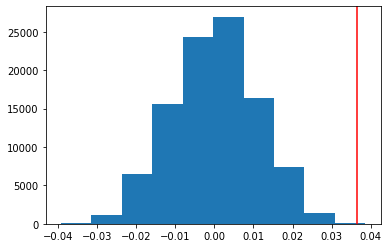

In [9]:
import matplotlib.pyplot as plt

sub_df = cat_df[cat_df["category"] == "LGBTI"]
context = sub_df[sub_df["context"] == "title"]["recall"]
no_context = sub_df[sub_df["context"] == "none"]["recall"]

mu_c = context.mean()
mu_n = no_context.mean()

perm = np.hstack([context, no_context])
N = 100_000
half = perm.shape[0] // 2

dist = []
for i in range(N):
    np.random.shuffle(perm)
    a = perm[:half].mean()
    b = perm[half:].mean()
    dist.append(a - b)
    
plt.hist(dist)
plt.axvline(mu_c - mu_n, color="red")
len([x for x in dist if x > (mu_c - mu_n)]) / len(dist)

0.00018

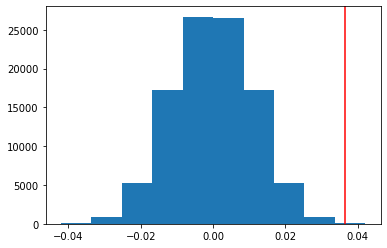

In [10]:
import matplotlib.pyplot as plt

sub_df = cat_df[cat_df["category"] == "LGBTI"]
context = sub_df[sub_df["context"] == "title"]["recall"]
no_context = sub_df[sub_df["context"] == "none"]["recall"]

mu_c = context.mean()
mu_n = no_context.mean()

perm = np.hstack([context, no_context])
N = 100_000
half = perm.shape[0] // 2

dist = []
for i in range(N):
    np.random.shuffle(perm)
    a = perm[:half].mean()
    b = perm[half:].mean()
    dist.append(a - b)
    
plt.hist(dist)
plt.axvline(mu_c - mu_n, color="red")
len([x for x in dist if x > (mu_c - mu_n)]) / len(dist)

### Bootstrap testing

In [11]:
sdf.loc["LGBTI"]["recall mean"]

context
none          0.403077
title         0.439658
title+body    0.435556
Name: recall mean, dtype: float64

In [12]:
cat_df.sort_values("recall", inplace=True)

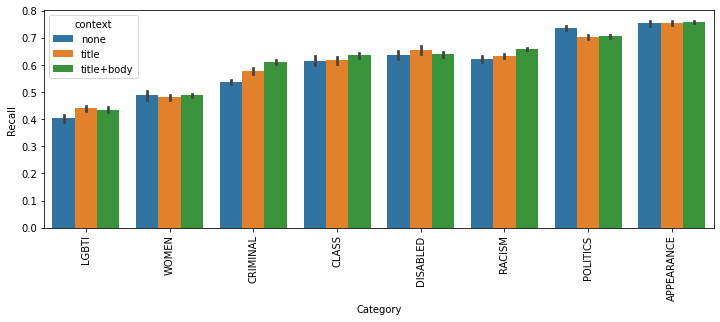

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.barplot(data=cat_df, x="category", y="recall", hue="context")

plt.xticks(rotation=90)
plt.ylabel("Recall")
plt.xlabel("Category")

plt.savefig("imgs/recall_category.png")

## Error Analysis

In [21]:
import torch 
from tqdm.auto import tqdm

df = test_dataset.to_pandas()
#df.drop(["token_type_ids", "attention_mask"], axis=1, inplace=True)
#df["context_pred"] = context_prediction.predictions.argmax(axis=1)
#df["no_context_pred"] = no_context_prediction.predictions.argmax(axis=1)

df.set_index("id", inplace=True)

for context, evals in evaluations.items(): 
    num_evals = len(evals)

    sum_preds = torch.zeros(len(test_dataset))
    for evaluation in tqdm(evals):
        preds = torch.Tensor(evaluation["predictions"]).argmax(1)
        sum_preds += preds
    
    df[f"{context}_prob"] = sum_preds.cpu().numpy() / num_evals
    df[f"{context}_pred"] = df[f"{context}_prob"] > 0.5
df

,APPEARANCE,CALLS,CLASS,CRIMINAL,DISABLED,HATEFUL,LGBTI,POLITICS,RACISM,WOMEN,body,text,title,no_context_prob,no_context_pred,title_prob,title_pred,full_context_prob,full_context_pred
id,,,,,,,,,,,,,,,,,,,
397703,0,0,0,0,0,0,0,0,0,0,"Puede marcar con justeza la fecha de inicio de la crisis: hace 10 meses que no brinda clases. En cambio, no logra avizorar el día que concluirá: ""No sabemos cuándo empezamos, cuando volvemos a tra...",[USER] Ojalá se funda y cague de hambre,"Mora Godoy cierra su escuela de tango y remata su vestuario para ""poder seguir adelante""",0.000000,False,0.000000,False,0.000000,False
397704,0,0,0,0,0,1,0,0,0,1,"Puede marcar con justeza la fecha de inicio de la crisis: hace 10 meses que no brinda clases. En cambio, no logra avizorar el día que concluirá: ""No sabemos cuándo empezamos, cuando volvemos a tra...",[USER] Faltó que se enganchó al hijo de sofovich para seguir adelante [EMOJI] cara con mano sobre la boca [EMOJI],"Mora Godoy cierra su escuela de tango y remata su vestuario para ""poder seguir adelante""",0.000000,False,0.000000,False,0.000000,False
397705,0,0,0,0,0,0,0,0,0,0,"Puede marcar con justeza la fecha de inicio de la crisis: hace 10 meses que no brinda clases. En cambio, no logra avizorar el día que concluirá: ""No sabemos cuándo empezamos, cuando volvemos a tra...","[USER] y bue, que le vaya a llorar a Cristina ahora...\nes políticamente incorrecto lo sé, pero que lindo es ver morder el suelo a estos forros que hicieron de todo por boicotear al gobierno anter...","Mora Godoy cierra su escuela de tango y remata su vestuario para ""poder seguir adelante""",0.000000,False,0.000000,False,0.000000,False
397706,0,0,0,0,0,0,0,0,0,0,"Puede marcar con justeza la fecha de inicio de la crisis: hace 10 meses que no brinda clases. En cambio, no logra avizorar el día que concluirá: ""No sabemos cuándo empezamos, cuando volvemos a tra...","[USER] [USER] Jodete. Macri te hizo conocer a Obama y que bailaras con él, Fernández te hace vender el vestuario a la Yenifer. tugo","Mora Godoy cierra su escuela de tango y remata su vestuario para ""poder seguir adelante""",0.000000,False,0.000000,False,0.000000,False
397707,0,0,0,0,0,0,0,0,0,0,"Puede marcar con justeza la fecha de inicio de la crisis: hace 10 meses que no brinda clases. En cambio, no logra avizorar el día que concluirá: ""No sabemos cuándo empezamos, cuando volvemos a tra...","[USER] Que se joda, es su gobierno el que ella defendió; de bailar con Obama a quedarse sin nada con Alberso.. [EMOJI] mano con señal de victoria tono de piel claro medio [EMOJI][EMOJI] botella de...","Mora Godoy cierra su escuela de tango y remata su vestuario para ""poder seguir adelante""",0.000000,False,0.000000,False,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361071,0,0,0,0,0,0,0,0,0,0,"La defensa de Nahir Galarza, condenada el 3 de julio de 2018 a prisión perpetua por asesinato de Fernando Pastorizzo, anunció que la abogada con perspectiva feminista María Raquel Hermida Leyenda ...",[USER] Con esa varita q no rompe un plato ni salta un venao !!!,"Nahir Galarza sumó a una abogada feminista a su defensa: ""Buscamos un juicio con perspectiva de género""",0.066667,False,0.066667,False,0.933333,True
361072,0,0,0,0,0,1,0,0,0,1,"La defensa de Nahir Galarza, condenada el 3 de julio de 2018 a prisión perpetua por asesinato de Fernando Pastorizzo, anunció que la abogada con perspectiva feminista María Raquel Hermida Leyenda ...",[USER] No las entiendo a estas pelotudas. Somos iguales o solo cuando les conviene?!,"Nahir Galarza sumó a una abogada feminista a su defensa: ""Buscamos un juicio con perspectiva de género""",0.000000,False,0.000000,False,0.000000,False
361073,0,0,0,0,0,0,0,0,0,0,"La defensa de Nahir Galarza, condenada el 3 de julio de 2018 a prisión perpetua por asesinato de Fernando Pastorizzo, anunció que la abogada con perspectiva feminista María Raquel Hermida Leyenda ...",[USER] Lo mató por qué es macho!,"Nahir G

In [22]:
sum(df["title_pred"] != df["no_context_pred"])

435

Hagamos un barplot de la performance de la detección para cada categoría

- Para categoría C, me fijo la recall de cada clasificador en esa categoría

Ojo que es distinto que la tarea de categorización



In [23]:
import pandas as pd

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 400

#df[(df["DISABLED"] != 0) & (df["no_context_pred"] == 0)][["title", "text", "no_context_pred", "context_pred", "labels", "DISABLED"]]

## ¿Cuánto da el f1 usando estos "ensembles"?

In [24]:
from sklearn.metrics import f1_score


f1_score(df["HATEFUL"], df["no_context_pred"]), f1_score(df["HATEFUL"], df["title_pred"]), f1_score(df["HATEFUL"], df["full_context_pred"])

(0.6531365313653136, 0.6900031535793125, 0.6836702954898911)

## On hateful messages

In [25]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 300

mismatches = df[df["title_pred"] != df["no_context_pred"]]

hateful = mismatches[mismatches["HATEFUL"] > 0]

not_hateful = mismatches[mismatches["HATEFUL"] == 0]

columns = ["title", "text", "title_pred", "no_context_pred", "HATEFUL"] 

hateful[columns].sort_values("no_context_pred", ascending=False)

,title,text,title_pred,no_context_pred,HATEFUL
id,,,,,
397749,"Mora Godoy cierra su escuela de tango y remata su vestuario para ""poder seguir adelante""",[USER] Jodete ka ka,False,True,1
405362,Una mujer trans fue asesinada de una ráfaga de 20 disparos en Rosario,[USER] Cómo no saco su escopeta y aplicó la defensa propia?!,False,True,1
333383,El exabrupto de Rodolfo Barili con una modelo que se metió en el baúl de un auto para violar la cuarentena,"[USER] Y se quedó corto. ESTÚPUDA, HUEVA, GATO y más. Con RAZÓN [EMOJI] manos aplaudiendo [EMOJI]",False,True,1
349335,"Paul McCartney: ""Los chinos necesitan ser más limpios y menos medievales""","[USER] Los Chinos deben extinguirse, y occidente los tiene que ayudar a que eso pase...",False,True,1
368085,"Martha Rosenberg: ""En situación de pandemia, legalizar el aborto es más urgente que nunca""",[USER] Propongo eutanasia a las de pañuelo verde.,False,True,1
395562,Murió Diego Maradona: Viviana Canosa se enojó por la decisión de velarlo en la Casa Rosada,[USER] Esta perra rabiosa nunca le importo la gente el pueblo Diego es eso es el pueblo y se merecía que se lo despida en la casa del pueblo,False,True,1
333816,"""Comemurciélagos"" y ""fabricantes de virus"": la ira de una estrella del rock contra China por la pandemia de coronavirus",[USER] Concuerdo,False,True,1
377081,"Femicidio en Catamarca: ""No es gente enferma, sino que tiene una formación machista importante""","[USER] Era aliade Clarín, iba a las marchas feminazistas, usaba pañuelo verde y levantaba la bandera LGTB. Vean su perfil",False,True,1
336745,Pidieron la detención de la mujer que violó la cuarentena y les arrojó gas pimienta a los policías,[USER] excedida en lípidos tenia que ser para andar resentida social por el mundo,False,True,1


## No odiosos

Veamos acá, que es donde mejora el contextualizado


**Hipótesis**: al parecer, muchos de los falsos positivos sin contexto corresponden a "insultos" o "celebraciones" que darían a entender el festejo de una muerte. Sin embargo, el contexto ayuda a desambiguar el sentido del mensaje.

Esto puede ser un subproducto de algunas notas (particularmente aquellas policiales) que celebran muertes y dependen fuertemente del contexto. A su vez, la naturaleza de los mensajes discriminatorios (como fueron planteados en el manual de anotación) son de naturaleza compleja y compuesta de acuerdo al contexto. 

- Los activistas negros se preguntan: ¿la gente blanca protesta por moda?	|| [USER] Los negros se quejan que los blancos los matan, ahora se quejan que los blancos protestan con ellos, mas rompe bolas no habia, no?
- Mora Godoy cierra su escuela de tango y remata su vestuario para "poder seguir adelante" || [USER] Adoro los finales felices.
- Ginés González García explicó por qué el Gobierno no llegó a un acuerdo con Pfizer por la vacuna || [USER] Gracias por tanto heroe
- China: se derrumbó un hotel usado para la cuarentena de afectados de coronavirus	[USER] Que parezca un accidente...
- En 2018 se registró la tasa más baja de natalidad de las últimas décadas y el tema no parece importarles a nuestros dirigentes [USER] Una buena noticia!
- En 2018 se registró la tasa más baja de natalidad de las últimas décadas y el tema no parece importarles a nuestros dirigentes [USER] Traer hijos a este País no sirve


In [37]:
not_hateful = not_hateful.copy()
columns = ["title", "text", "no_context_pred", "title_pred", "no_context_prob", "title_prob"]

not_hateful["diff"] = not_hateful["no_context_prob"] - not_hateful["title_prob"] 
not_hateful[not_hateful["no_context_pred"] == 1].sort_values("diff", ascending=False)[columns]

,title,text,no_context_pred,title_pred,no_context_prob,title_prob
id,,,,,,
372982,"Hugo Moyano respaldó al Gobierno, criticó a Macri y minimizó las marchas de ""mujeres bien vestidas y alimentadas""",[USER] O sea...\nSus mujeres están mal vestidas y mal alimentadas\nO sea.,True,False,1.000000,0.000000
395329,"El exabrupto de Jair Bolsonaro sobre el coronavirus en Brasil: ""Tienen que dejar de ser un país de maricas""",[USER] Que capo!,True,False,1.000000,0.000000
343077,Coronavirus: Baby Etchecopar dio positivo en el test de Covid-19,[USER] Justicia divina,True,False,1.000000,0.000000
330632,China: se derrumbó un hotel usado para la cuarentena de afectados de coronavirus,[USER] Que parezca un accidente...,True,False,1.000000,0.000000
406500,La aberrante arenga machista que dio el preparador físico de Güemes de Santiago del Estero,[USER] Un capo.,True,False,1.000000,0.000000
372939,"Hugo Moyano respaldó al Gobierno, criticó a Macri y minimizó las marchas de ""mujeres bien vestidas y alimentadas""",[USER] Pero si él está bien alimentado tambien. O no?[EMOJI] cara pensativa [EMOJI],True,False,1.000000,0.000000
362710,"Leche de cucaracha, la nueva bebida nutritiva: ¿quién se anima a probarla?","[USER] Tienen un montón de cucarachas ahí, así que pueden hacer hasta yogurt [EMOJI] cara llorando de risa [EMOJI][EMOJI] cara llorando de risa [EMOJI][EMOJI] cara llorando de risa [EMOJI]",True,False,0.933333,0.000000
360776,"Javier Milei confirmó que va ""a militar en política"" junto a José Luis Espert para que ""en 35 años la Argentina sea primera potencia mundial""",[USER] Otro parásito,True,False,0.933333,0.000000
372967,"Hugo Moyano respaldó al Gobierno, criticó a Macri y minimizó las marchas de ""mujeres bien vestidas y alimentadas""",[USER] Los que arrean a fuerza de choripan también están bien alimentados y tienen altas llantas ameo!!!,True,False,0.933333,0.000000


In [27]:
lgbti_hateful = hateful[hateful["LGBTI"] > 0]

lgbti_hateful[["context", "text", "context_pred", "no_context_pred", "labels"]].sort_values("context_pred")

,context,text,context_pred,no_context_pred,labels
id,,,,,
386430,"Tras los comentarios de J.K. Rowling, Emma Watson defendió al colectivo trans",[USER] Una mujer trans es mujer?,0,1,1
334720,"Jimena Barón y una profunda reflexión: ""Si fuera hombre sería alto macho""",[USER] Es mujer? Fuaaa,0,1,1
400793,Histórico: Mara Gómez fue habilitada y será la primera jugadora trans en el fútbol argentino,[USER] Va a tener mucha ventaja a favor por correr con 3 piernas,0,1,1
384518,"Santiago Cafiero repudió el ataque a C5N: ""Hay que desarmar el discurso del odio""",[USER] [USER] [USER] [USER] AL PARÁSITO SOCIAL DE CAFIERO CHUPALA PUTO,0,1,1
393566,EE.UU.: Biden nomina a una mujer transgénero para un puesto de alto nivel,"[USER] Es decir a un hombre . Maldito patriarcado, siempre triunfa.",0,1,1
403207,"La historia de Danny Wakefield: ""Soy trans masculino y acabo de dar a luz a mi primer hijo""","[USER] no existe tal cosa, si tienes órganos reproductores femeninos eres mujer",0,1,1
393930,"Pablo Duggan se casó con Karen, su novia venezolana: ""Estoy muy feliz de haberla conocido, me cambió la vida""","[USER] Novio venezolano,es un trabuco, digan la verdad.",0,1,1
333997,"Las lágrimas de Guillermo Andino tras recuperarse de coronavirus: ""El miedo es no poder contarla""",[USER] Re trolazo,0,1,1
401047,La impactante historia de la tenista trans que hoy es la N 3 de Argentina en la categoría senior femenino,[USER] Impactante debe ser verle los huevos cuando se le vuela la pollerita en el saque...,1,0,1


In [58]:
from hatedetection.predict import predict_hateful

predict_hateful(context_model, tokenizer, "[USER] Mariana es hombre y debería llamarse Mariano, no intenten confundir", context="Por qué Mariana Genesio Peña no continúa en su programa de la noche")

[CLS] por qué mariana genesio peña no continúa en su programa de la noche [SEP] [USER] mariana es hombre y debería llamarse mariano, no intenten confundir [SEP]


False

In [77]:
hateful["context_pred"].sum(), hateful["no_context_pred"].sum(), len(hateful)

(218, 69, 287)

In [79]:
not_hateful["context_pred"].sum(), not_hateful["no_context_pred"].sum(), len(not_hateful)

(169, 169, 338)

Acá se equivocan exactamente lo mismo

In [85]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 400

not_hateful[["context", "text", "context_pred", "no_context_pred", "labels"]].sort_values("no_context_pred", ascending=False)

,context,text,context_pred,no_context_pred,labels
id,,,,,
331494,Por qué Paraguay es el país que tuvo el menor impacto del coronavirus en Sudamérica,"[USER] Porque la mandioca es la cura del coronavirus, me lo dijo [USER]",0,1,0
369651,"Máximo Kirchner: ""Mauricio Macri es mucho mejor turista de lo que fue como Presidente""",[USER] Ustedes son mejor mierdas que soretes.,0,1,0
394343,"Quién es Sabino Vaca Narvaja, el hijo de un fundador de Montoneros que se hará cargo de la Embajada en China",[USER] Por lo menos habla chino el burro ese?,0,1,0
388818,"El nuevo problema de salud de Jimena Barón en Miami: ""Me voy a tener que operar""","[USER] Guácala, que me importa. [EMOJI] cara de náuseas [EMOJI][EMOJI] cara vomitando [EMOJI]",0,1,0
348613,La nueva cepa del virus de la gripe porcina se está propagando a los humanos en China,[USER] Y te convertís en cerdo!!! Como ustedes q se aburrieron del covid y bueno instalemos ésto y sigamos a$u$ tando a la gente [EMOJI] pulgar hacia abajo [EMOJI],0,1,0
382889,"Luego de mentir sobre el peligro del salmón, el régimen chino le apuntó ahora al camarón como transmisor del coronavirus",[USER] [EMOJI] hombre con la mano en la frente [EMOJI] me cago en los chinos...,0,1,0
397162,"El papa Francisco recordó a las víctimas del Holocausto y advirtió: ""Estas cosas pueden volver a suceder""",[USER] Seguro que lo de Formosa no se entero[EMOJI] cara pensativa [EMOJI][EMOJI] hombre con la mano en la frente tono de piel claro [EMOJI],0,1,0
328295,Coronavirus en Argentina: una mujer que volvió de Italia se escapó del hospital para no hacerse los estudios,[USER] Menos mal que no se le escapó al coreano porque no le hubiera hecho falta el hisopado [EMOJI] gato llorando de risa [EMOJI][EMOJI] gato llorando de risa [EMOJI],0,1,0
381672,"Coronavirus: una por una, todas las nuevas medidas anunciadas por el presidente Alberto Fernández",[USER] [USER] Q los CHINOS abandonen Paraguay ya,0,1,0


## Error Analysis

In [62]:
from datasets import ClassLabel
from hatedetection import extended_hate_categories

PAD_IDX = tokenizer.vocab["[PAD]"]

def decode(example):
    """
    Returns what the BERT models get as input
    """
    input_ids = [x.item() for x in example["input_ids"] if x.item() != PAD_IDX]
    return tokenizer.decode(input_ids)




df["tokenized_text"] = df.apply(decode, axis=1)
#dev_df = dev_df[["text", "context", "tokenized_text", "labels"] + extended_hate_categories]

<AxesSubplot:ylabel='index'>

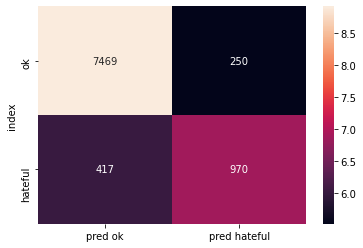

In [69]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(df["labels"], df["context_pred"])
)

cm.columns = ["pred ok", "pred hateful"]

cm["index"] = ["ok", "hateful"]

cm.set_index("index", inplace=True)

normalized = np.log(1+cm)
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
sns.heatmap(normalized, annot=cm, fmt="")

<AxesSubplot:ylabel='index'>

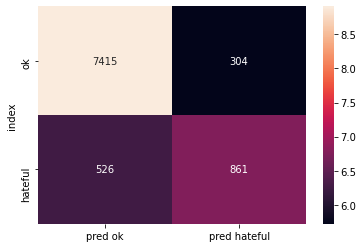

In [70]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(df["labels"], df["no_context_pred"])
)

cm.columns = ["pred ok", "pred hateful"]

cm["index"] = ["ok", "hateful"]

cm.set_index("index", inplace=True)

normalized = np.log(1+cm)
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
sns.heatmap(normalized, annot=cm, fmt="")

## Errors

In [72]:
df["predicted"] = df["context_pred"] > 0


In [74]:
false_negatives = df.loc[((~df["predicted"]) & (df["labels"])) != 0]

false_positives = df.loc[((df["predicted"]) & (~df["labels"])) != 0]

columns = ["text", "context", "tokenized_text"] + extended_hate_categories
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

In [77]:
false_negatives.sample(10)

,text,context,tokenized_text,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL
id,,,,,,,,,,,,
349815,"[USER] Y si dejamos de comprar "" Made in china"" y se vuelven a morir de hambre como en la época de Mao?","China: Xi Jinping llamó a sus soldados a ""prepararse para la guerra""","[CLS] china : xi jinping llamó a sus soldados a "" prepararse para la guerra "" [SEP] [USER] y si dejamos de comprar "" made in china "" y se vuelven a morir de hambre como en la época de mao? [SEP]",1,0,0,1,0,0,0,0,0
404668,"[USER] Van a solo darle uso para aspirar cocaina. Una investigación analizó que los billetes de circulación que hoy tenés en tu billetera, contienen cocaina entre las fibras del papel moneda. No sólo acá, en el mundo entero.[EMOJI] hombre con la mano en la frente [EMOJI]",Senadores kirchneristas proponen que la mitad de los nuevos billetes de $1.000 tengan la cara de Maradona,"[CLS] senadores kirchneristas proponen que la mitad de los nuevos billetes de $ 1. 000 tengan la cara de maradona [SEP] [USER] van a solo darle uso para aspirar cocaina. una investigación analizó que los billetes de circulación que hoy tenés en tu billetera, contienen cocaina entre las fibras del papel moneda. no sólo acá, en el mundo entero. [EMOJI] hombre con la mano en la frente [EMOJI] [SEP]",0,0,0,0,0,0,1,0,0
356897,[USER] La resen,Río Gallegos: una mujer destruyó a palazos el auto de alta gama de su ex pareja,[CLS] río gallegos : una mujer destruyó a palazos el auto de alta gama de su ex pareja [SEP] [USER] la resen [SEP],0,1,0,0,0,0,0,0,0
337642,"[USER] Los primeros en aprender de sus errores deben ser Uds, nosotros jamás asimilamos en nuestra cultura, las atrocidades q Uds hacen con la fauna silvestre, no admitimos esos comportamientos, Uds contagiaron al mundo y hoy quieren dar consejos, primero CAMBIEN","Wuhan celebra el fin de la cuarentena por el coronavirus con un mensaje para el resto del mundo: ""Aprendan de nuestros errores""","[CLS] wuhan celebra el fin de la cuarentena por el coronavirus con un mensaje para el resto del mundo : "" aprendan de nuestros errores "" [SEP] [USER] los primeros en aprender de sus errores deben ser uds, nosotros jamás asimilamos en nuestra cultura, las atrocidades q uds hacen con la fauna silvestre, no admitimos esos comportamientos, uds contagiaron al mundo y hoy quieren dar consejos, primero cambien [SEP]",0,0,0,1,0,0,0,0,0
344239,[USER] Caminemos a Luján para apoyar este santo,"Coronavirus en Argentina: un dirigente radical deseó que la pandemia ""haga una limpieza étnica"" con ""negros de La Matanza""","[CLS] coronavirus en argentina : un dirigente radical deseó que la pandemia "" haga una limpieza étnica "" con "" negros de la matanza "" [SEP] [USER] caminemos a luján para apoyar este santo [SEP]",0,0,0,1,1,0,0,0,0
372322,[USER] Panzón pelotudo,Alberto Fernández le agradeció al Chacho Coudet la cerveza personalizada que le envió,[CLS] alberto fernández le agradeció al chacho coudet la cerveza personalizada que le envió [SEP] [USER] panzón pelotudo [SEP],0,0,0,0,0,0,0,1,0
393954,[USER] De sentarse en el pinocho a comer moluscos! Ni vos te la crees Duggan,"Pablo Duggan se casó con Karen, su novia venezolana: ""Estoy muy feliz de haberla conocido, me cambió la vida""","[CLS] pablo duggan se casó con karen, su novia venezolana : "" estoy muy feliz de haberla conocido, me cambió la vida "" [SEP] [USER] de sentarse en el pinocho a comer moluscos! ni vos te la crees duggan [SEP]",0,0,1,0,0,0,0,0,0
367467,[USER] Siempre los chinos metidos en cada quilombo posible ... son como langostas ...,Los pesqueros chinos están poniendo en riesgo la supervivencia de diversas especies animales en las islas Galápagos,[CLS] los pesqueros chinos están poniendo en riesgo la supervivencia de diversas especies animales en las islas galápagos [SEP] [USER] siempre los chinos metidos en cada quilombo posible... son como langostas... [SEP],0,0,0,1,0,0,0,0,0
359910,[USER] Qué pena lo tuyo pibe! Cada vez más derechoso...

In [76]:
false_positives.sample(10)

,text,context,tokenized_text,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL
id,,,,,,,,,,,,
370092,usuario Hacer lo que uno quiere se llama LIBERTAD no feminismo...que conceptos equivocados tenés...,"Florencia Peña: “No debe ser fácil ser hijo mío, pero como mamá estoy a la altura de la circunstancia”","[CLS] Florencia Peña : [UNK] No debe ser fácil ser hijo mío, pero como mamá estoy a la altura de la circunstancia [UNK] [SEP] usuario Hacer lo que uno quiere se llama LIBERTAD no feminismo... que conceptos equivocados tenés... [SEP]",0,0,0,0,0,0,0,0,0
404745,"usuario Si el que va a tener al bebé es el que parece hombre, entonces no es trans , es travesti.","Historia: Franco, un hombre trans, tendrá un hijo con Hannah, una mujer trans","[CLS] Historia : Franco, un hombre trans, tendrá un hijo con Hannah, una mujer trans [SEP] usuario Si el que va a tener al bebé es el que parece hombre, entonces no es trans, es travesti. [SEP]",0,0,0,0,0,0,0,0,0
339575,usuario UN CHINO NEGRO !,El extraño cambio en el color de la piel de dos médicos que sobrevivieron al coronavirus en Wuhan,[CLS] El extraño cambio en el color de la piel de dos médicos que sobrevivieron al coronavirus en Wuhan [SEP] usuario UN CHINO NEGRO! [SEP],0,0,0,0,0,0,0,0,0
352492,usuario Que país del orto. Ni robar en paz se puede ahora que lo tirotean a uno.,Un preso que participó del motín en Devoto y fue liberado con la excusa del coronavirus salió a robar y fue herido en un tiroteo con la Policía,[CLS] Un preso que participó del motín en Devoto y fue liberado con la excusa del coronavirus salió a robar y fue herido en un tiroteo con la Policía [SEP] usuario Que país del orto. Ni robar en paz se puede ahora que lo tirotean a uno. [SEP],0,0,0,0,0,0,0,0,0
384426,usuario Aysa es de la Nación... Si quieren estos CHORROS K QUE Aysa sea solo responsabilidad de la Ciudad. Que Cada Provincia haga su planta Potabilizadora y distribución . L9S CHORROS KURCHNERISTAS COMO NO SABEN GESTIONAR Y SOLO SABEN ROBAR DINERO DE LOS IMPUESTOS. KULPAN A LOS DEMAS.,Interna por la Villa 31: AySA apunta al Gobierno de la Ciudad por la falta de agua,[CLS] Interna por la Villa 31 : AySA apunta al Gobierno de la Ciudad por la falta de agua [SEP] usuario Aysa es de la Nación... Si quieren estos CHORROS K QUE Aysa sea solo responsabilidad de la Ciudad. Que Cada Provincia haga su planta Potabilizadora y distribución. L9S CHORROS KURCHNERISTAS COMO NO SABEN GESTIONAR Y SOLO SABEN ROBAR DINERO DE LOS IMPUESTOS. KULPAN A LOS DEMAS. [SEP],0,0,0,0,0,0,0,0,0
402742,usuario SSHH.... HAY MÁS MUGRE ADENTRO Q AFUERA....,“Basurero de la democracia”: cómo quedó Tribunales tras el paso de la marcha por Milagro Sala,[CLS] [UNK] Basurero de la democracia [UNK] : cómo quedó Tribunales tras el paso de la marcha por Milagro Sala [SEP] usuario SSHH.... HAY MÁS MUGRE ADENTRO Q AFUERA.... [SEP],0,0,0,0,0,0,0,0,0
400542,usuario Seguramente la queria poner,Tucumán: masivo respaldo a un joven que fue al acto de graduación en pollera y las autoridades del colegio lo obligaron a cambiarse,[CLS] Tucumán : masivo respaldo a un joven que fue al acto de graduación en pollera y las autoridades del colegio lo obligaron a cambiarse [SEP] usuario Seguramente la queria poner [SEP],0,0,0,0,0,0,0,0,0
388725,usuario Dónalo papu,"Miguel Herrán, Río en La Casa de Papel, y el lado oscuro de su éxito: “El dinero me ha ensuciado como persona”","[CLS] Miguel Herrán, Río en La Casa de Papel, y el lado oscuro de su éxito : [UNK] El dinero me ha ensuciado como persona [UNK] [SEP] usuario Dónalo papu [SEP]",0,0,0,0,0,0,0,0,0
341477,"usuario No son clientes, son prostituyentes!",Coronavirus: el Papa envió ayuda a transexuales que se quedaron sin clientes,"[CLS] Coronavirus : el Papa envió ayuda a transexuales que se quedaron sin clientes [SEP] usuario No son clientes, son prostituyentes! [SEP]",0,0,0,0,0,0,0,0,0


Veamos en qué categorías falla más


In [71]:
hateful = dev_df[dev_df["labels"] == 1]

std = hateful[extended_hate_categories].std()
(false_negatives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.16003
WOMEN         0.18792
LGBTI         0.07151
RACISM       -0.02460
CLASS         0.07151
POLITICS     -0.01147
DISABLED      0.03928
APPEARANCE   -0.14719
CRIMINAL     -0.17322
dtype: float64

A ver, de lo que vemos:

- Hay sustancialmente más falsos negativos sobre la categoría mujer => veamos ahí!
- Hay muy pocos de apariencia

In [72]:
(false_positives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.47331
WOMEN        -0.43051
LGBTI        -0.32420
RACISM       -0.66105
CLASS        -0.32420
POLITICS     -0.43754
DISABLED     -0.25542
APPEARANCE   -0.49147
CRIMINAL     -0.46874
dtype: float64

Con **falsos positivos** tenemos:

- 